# Pretrained Transformers and Transfer Learning

In [29]:
import numpy as np
import torch 
from datasets import load_dataset

cache_dir = "./data_cache"

In [30]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/C289216/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 4. Pretrained Transformers

HuggingFace is a company that has developed an open source library for loading pretrained transformer models. They also distribute many models that have been pretrained using language modelling tasks, or fine-tuned to specific downstream NLP tasks.  It is currently the best library to use to create NLP models on top of large, deep neural networks. This is especially useful for tasks where simpler, feature-based methods or smaller LSTM models do not perform well enough, for example, when complex processing of syntax and semantics is required (natural language 'understanding'). 

Let's start by looking at two key types of object in the transformers library: models and tokenizers.

## 4.1. Models

The neural network models available in the Transformers library are accessed through wrapper classes such as `AutoModel`. If we want to load a pretrained model, we can simply pass its name to the `from_pretrained` function, and the pretrained model weights will be downloaded from HuggingFace and a neural network model will be created with those weights. For example:

In [31]:
from transformers import AutoModel # For BERTs

model = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D") 

This code loads the TinyBERT model, which is a compressed version of BERT. It has 4.4 million parameters, compared to the standard version of BERT, 'BERT-base', which has 110 million parameters. While TinyBERT will not perform as well as larger models, we will use it for this notebook to save memory and computation costs. See [documentation here](https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D).

<!--the RoBERTa variant of BERT. It has 4.4 million parameters, compared to the standard version of BERT, 'BERT-base', which has 110 million parameters. While RoBERTa-tiny will not perform as well as larger models, we will use it for this notebook to save memory and computation costs. See [documentation here](https://huggingface.co/arampacha/roberta-tiny).  -->

The same functions can be used to load other models from HuggingFace's repository simply by changing the model's name. Take a look at [the Models page](https://huggingface.co/models) to see what there is on offer. Do you recognise any of the models' names?

# 4.2. Tokenizers

Before we can apply a model to some text, we need to a create Tokenizer object. In Transfomers, Tokenizer objects convert raw text to a sequence of numbers. First, the tokenizer actually performs tokenization, then it maps each token to its numerical ID. There are lots of different tokenizers that we can use to preprocess text. If we are loading a pretrained model, we will need to choose the tokenizer that corresponds to that model. 

We can load the right tokenizer as follows, in the same way we loaded the model itself:

In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

Let's see what the TinyBERT tokenizer does to an example sentence:

In [33]:
sentence = "The transformer architecture has transformed the field of NLP."

tokens = tokenizer.tokenize(sentence)
print(tokens)

['the', 'transform', '##er', 'architecture', 'has', 'transformed', 'the', 'field', 'of', 'nl', '##p', '.']


Let's compare with the NLTK tokenizer we have seen before:

In [34]:
from nltk.tokenize import word_tokenize

nltk_tokens = word_tokenize(sentence)
print(nltk_tokens)

['The', 'transformer', 'architecture', 'has', 'transformed', 'the', 'field', 'of', 'NLP', '.']


While NLTK keeps whole words as tokens, the BERT tokenizer splits some words into sub-words and inserts some special characters into the tokens. Splitting is applied to words with low frequency in the training set, such as 'transformer'. 

Why does you think BERT splits some words into sub-word tokens?

The BERT tokenizer splits some words into sub-words as a way to improve the handling of words that have not been seen before (or very infrequently seen) in the training corpus. This allows the model to see a sub-word that may exist as a part of another input token, and this sub-word will have been more frequently seen in the vocabulary allowing for preservation of semantic meaning compared to dropping the work entirely. This is particually beneficial for use with complex words. In the example of the word 'transformer' being split into 'transform', '##er', we can see the tokeniser at work. 'transform' has been seen more commonly so is split out into a separate word followed by the suffix '##er' where '##' represents that it is joined to the preceding token with no space. 

---

It is important to use the right tokenizer with a pretrained model as each model was trained with text tokenized in a particular way. After tokenization, the Tokenizer object can also map the tokens to their IDs (indexes in the vocabulary):

In [35]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[1996, 10938, 2121, 4294, 2038, 8590, 1996, 2492, 1997, 17953, 2361, 1012]


## 4.3. Contextualised Embeddings

Now that we have a sequence of tokens, we are almost ready to process the sequence using the pretrained model. 

Our model takes as input a PyTorch `tensor` object. In PyTorch, `tensor` is a muli-dimensional matrix. Here, we need a two-dimensional matrix, where each row is a sequence of input tokens corresponding to a single sentence or document. Let's convert our list of IDs to a 2-D tensor with a single row:

In [36]:
ids_tensor = torch.tensor([ids])

print(ids_tensor)

tensor([[ 1996, 10938,  2121,  4294,  2038,  8590,  1996,  2492,  1997, 17953,
          2361,  1012]])


Now we can process the sequence using our model. The model maps the sequence of input IDs to a sequence of output vectors, which are contextualised word embeddings. The hidden state values produced in the last hidden layer of the model are used as the contextualised embeddings:

In [37]:
model_outputs = model(ids_tensor)
print('The complete model outputs: ')
print(model_outputs)

print()
print('The last hidden state for the first token in the sequence (the first word embedding): ')
embeddings = model_outputs['last_hidden_state'][0]
print(embeddings)

The complete model outputs: 
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3608,  0.2862, -0.1549,  ..., -0.2064,  0.2663, -0.0109],
         [ 0.0149,  0.7223, -0.0508,  ..., -0.5505,  0.2355, -0.2962],
         [ 0.1531,  0.5903, -0.1244,  ..., -0.4263,  0.0417, -0.1839],
         ...,
         [ 0.1742, -0.1091, -0.1963,  ..., -0.6736,  0.0472, -0.1840],
         [ 0.2434,  0.1021, -0.2241,  ..., -0.5400, -0.1691, -0.1314],
         [ 0.0854,  0.3272, -0.3016,  ..., -0.2154, -0.5632, -0.1921]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-1.1380e-02, -6.3005e-03,  1.8521e-02,  7.1139e-03, -3.1795e-02,
          1.3882e-02, -1.5459e-02, -1.0610e-03, -1.8263e-02, -3.6515e-02,
         -2.1257e-02, -1.5479e-02, -2.8092e-04, -4.1092e-02, -2.5315e-02,
         -4.3338e-02, -1.1616e-03, -1.3931e-02,  6.0733e-03,  4.3790e-03,
          2.7095e-04, -2.1810e-02, -4.8027e-02,  2.5493e-02, -1.6502e-02,
         -1.2033e-03,  4.2757e-02,  3.

We can retrieve the embedding vector for "transform" like this ("transform" is the second token in the sequence):

In [38]:
emb = embeddings[1]  # get second embedding in the sequence

# convert it to a numpy array so we can perform various operations on it later on
emb = emb.detach().numpy()

print(emb)
print(f'The TinyBERT embeddings have {emb.shape[0]} dimensions.')

[ 1.49147697e-02  7.22317696e-01 -5.07858247e-02 -2.74206161e-01
 -1.38932481e-01  1.00099695e+00  7.11505115e-03  2.71392018e-01
 -3.92812826e-02  6.04101568e-02  1.25740498e-01  4.60631430e-01
  6.25268929e-03  1.61930606e-01  1.23912975e-01 -4.08096462e-01
  1.24867812e-01 -4.71536398e-01  2.24768445e-01  6.35184646e-02
  8.56178552e-02 -1.88044518e-01  1.77258164e-01  3.40050459e-01
 -1.95546225e-01  1.58553511e-01  9.62863863e-02  1.12649024e-01
  2.21045852e-01 -9.56112742e-01 -3.85948181e-01  1.39220446e-01
  5.90012670e-01 -8.06727409e-01 -1.34288177e-01  2.35691234e-01
 -1.02274969e-01  2.78302491e-01  7.94321775e-01 -2.49362767e-01
  1.72771454e-01 -2.07582951e-01  3.00156057e-01 -8.59326720e-02
 -2.25285187e-01 -9.75407586e-02 -3.52348983e-01  3.81162286e-01
 -3.87680084e-01 -1.77613303e-01 -4.13685530e-01  1.38047144e-01
  1.29877329e-02  6.52685225e-01  1.16503283e-01 -5.10779440e-01
 -8.30419064e-02 -2.67046690e-02  3.12863111e-01 -2.62847960e-01
 -1.43285111e-01  1.10270

Here we retrieve the embedding for "architecture".

In [39]:
emb = embeddings[2]  # get second embedding in the sequence

# convert it to a numpy array so we can perform various operations on it later on
emb = emb.detach().numpy()

print(emb)

[ 1.53095931e-01  5.90333402e-01 -1.24389745e-01 -1.52344584e-01
 -1.50733650e-01  9.45182383e-01  8.33654776e-02 -2.53275968e-02
  3.34604550e-03 -5.66821918e-02  1.08500779e-01  3.36456835e-01
  1.94329485e-01  1.39977738e-01 -1.16448477e-03 -3.17851335e-01
  1.35712579e-01 -3.63934994e-01  2.86722660e-01  6.37838393e-02
  1.10133767e-01 -1.33100495e-01  1.21274859e-01  2.69983977e-01
 -2.07514375e-01  2.41632104e-01  1.74404651e-01  9.52016562e-02
  2.46267706e-01 -4.53010201e-01 -3.70885789e-01  2.27920219e-01
  5.26750386e-01 -7.93769360e-01 -1.29065424e-01  3.42485130e-01
 -7.25852028e-02  1.48398936e-01  9.29528236e-01 -1.95573792e-02
  1.74671739e-01 -2.60312200e-01  2.67400205e-01 -2.52537932e-02
 -2.44414568e-01 -6.59062788e-02 -3.49721700e-01  3.15456212e-01
 -3.61769289e-01 -2.38949716e-01 -2.53457814e-01  5.69549352e-02
 -2.64256448e-03  6.79622293e-01 -5.76044321e-02 -4.39989120e-01
  1.26866534e-01 -8.14858973e-02  3.19382310e-01 -2.88918197e-01
 -6.20062277e-03  9.45396

Sentences and documents usually have varying lengths. So, to put multiple sentences into a single tensor, we need to pad the sequences up to a maximum length. Luckily, the tokenizer class takes care of this for us. When we pass in a list of sentences, the tokenizer creates a matrix, where each row is a sequence of the same length:

In [40]:
sentences = [
    "I can book tickets for the concert next week.",
    "Many readers find the first book of A Tale of Two Cities to be confusing.",
    "She opened the book to page 37 and began to read aloud.",
    "The police wanted to book him for driving too fast.",
    "I can reserve tickets for the concert next week."
]

model_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")  

print(model_inputs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  101,  1045,  2064,  2338,  9735,  2005,  1996,  4164,  2279,  2733,
          1012,   102,     0,     0,     0,     0,     0,     0],
        [  101,  2116,  8141,  2424,  1996,  2034,  2338,  1997,  1037,  6925,
          1997,  2048,  3655,  2000,  2022, 16801,  1012,   102],
        [  101,  2016,  2441,  1996,  2338,  2000,  3931,  4261,  1998,  2211,
          2000,  3191, 12575,  1012,   102,     0,     0,     0],
        [  101,  1996,  2610,  2359,  2000,  2338,  2032,  2005,  4439,  2205,
          3435,  1012,   102,     0,     0,     0,     0,     0],
        [  101,  1045,  2064,  3914,  9735,  2005,  1996,  4164,  2279,  2733,
          1012,   102,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

`model_inputs` is a dictionary containing three objects:
 * The `input_ids` are the list of token IDs in the input sequences. 
 * The `attention_mask` records which tokens are special padding tokens and which are real tokens. Tokens with a 0 in the attention mask will be ignored.
 * `token_type_ids` is needed when two sequences are passed together as input to the model for tasks such as next sentence prediction that involve comparing two sentences. Here, each input is a single sentence, so we have only one type of token in the output above. 
 
0 is used to represent the special padding token.

Notice that the input_ids all start with the same token ID, 101, even though they have different first words. They also have token ID 102 before the padding tokens. This is because the tokenizer inserts two special tokens, which are used in some applicaions of BERT. 101 is the '[CLS]' token, which is a dummy token whose embedding can be trained to represent the whole sequence. the [CLS] token's embedding can then be used as input to a text classifier to classify a sentence or document. Token 102 is '[SEP]', which can be used to separate multiple input sequences in a single example. This is needed in tasks where multiple pieces of text are provided as input, e.g., a to build a classifier that can determine whether two sentences contradict each other. 

We can now pass all of the model inputs to the model to produce a set of contextualised embeddings:

In [41]:
# model_inputs is a dictionary, so to provide the arguments to model(), 
# we use the double star to unpack the dictionary so that each key in the dictionary is
# an argument to model() and each value is the value of the argument. 
model_outputs = model(**model_inputs) 

The first four example sentences above all contain the word "book", and the last example contains "reserve". We can obtain a list of contextualised word embeddings for 'book' and 'reserve' in the example sentences using our model.

In [42]:
# 2338 
# function to get an embedding for a given word in a given sentence
def get_pos_embedding(sentence, position):
    sentence_word_embeddings = model_outputs['last_hidden_state'][sentence]
    word_emb = sentence_word_embeddings[position]
    word_emb = word_emb.detach().numpy()
    return word_emb

book_embeddings = []
reserve_embeddings = []

book_embeddings.append(get_pos_embedding(0, 3))
book_embeddings.append(get_pos_embedding(1, 6))
book_embeddings.append(get_pos_embedding(2, 4))
book_embeddings.append(get_pos_embedding(3, 5))

reserve_embeddings.append(get_pos_embedding(4, 3))


Here we compute the similarities between these embeddings in the cell below, and show the results. We can explore how the embeddings relate to the meaning of the word "book" or "reserve" in each sentence.

From the generated plots shown below we can gain significant insight into the relationships between the different uses of the word book as how these a similar to the work ‘reserve’

- Sentence 0: "I can book tickets for the concert next week."
    - Has the greatest similarity with the use of the ‘book’ in sentence 2 with 0.63 cosine similarity.
    - Is is least similar to the use of the word ‘book’ in sentence 1 but has a similar similarity across all other sentences using book with 0.58 cosine similarity.
    - This is the most similar use of ‘book’, in the examples, to the use of the word ‘reserve’ in sentence 4  showing they have the most similar meaning with 0.74 cosine similarity.
    - This use of ‘book’ is more similar to the demonstrated use of the word ‘reserve’ than it is to all other examples of use of the word ‘book’
- Sentence 1: "Many readers find the first book of A Tale of Two Cities to be confusing."
    - Is not very similar to the use of the word ‘reserve’ in the example, with only 0.29 cosine similarity.
    - It has a high cosine similarity of 0.75 with the use of the word ‘book’ in sentence 2. 
    - It is least similar to the use of the word book in sentence 1 with 0.58 cosine similarity. 
- Sentence 2: “She opened the book to page 37 and began to read aloud."
    - Is not very similar to the use of the word ‘reserve’ in the example, with 0.29 cosine similarity.
    - It has a high cosine similarity of 0.75 with the use of the word ‘book’ in sentence 1. 
    - It is least similar to the use of the word book in sentence 3 with 0.44 cosine similarity. 
- Sentence 3: “The police wanted to book him for driving too fast."
    - Is somewhat similar to the example use of the word ‘reserve’ with cosine similarity of 0.5
    - It is most similar to the use of ‘book; in sentence 0 which is interesting because that is similar to the use of the word ‘reserve’ 
    - It is least similar to the use of the work ‘book’ in sentence 2. 


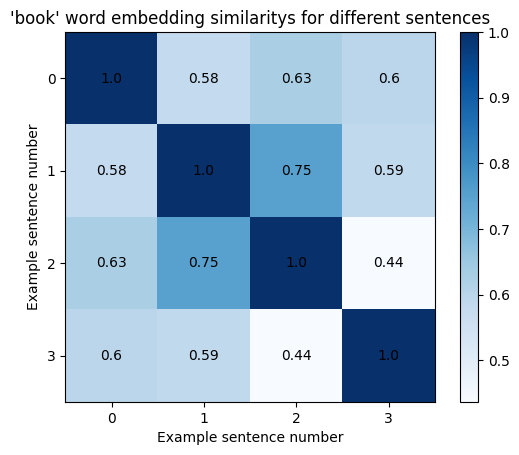

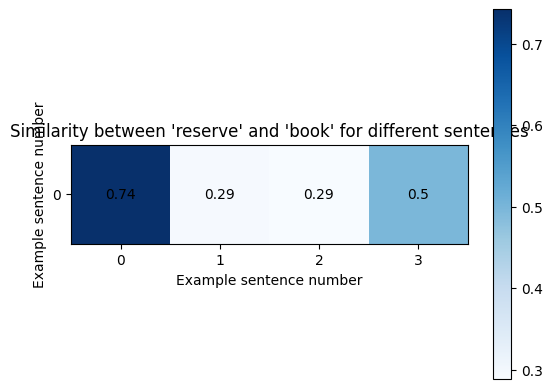

In [43]:
from scipy.spatial.distance import cdist  # you may find this function useful for computing distances

# computing the pairwise distance matrix
book_similarities = cdist(book_embeddings, book_embeddings, metric='cosine')
# for the scipy.spatial.distance calculation a smaller values indicates greater similarity, this is reversed by subtracting the similarities from 1. 
book_similarities = 1 - book_similarities

reserve_book_similarities = cdist(reserve_embeddings, book_embeddings, metric='cosine')
reserve_book_similarities = 1 - reserve_book_similarities


import matplotlib.pyplot as plt


def plot_similarity(similarity_matrix, title):
    fig, ax = plt.subplots()
    cax = ax.imshow(similarity_matrix, cmap='Blues')

    # legend
    fig.colorbar(cax)

    # show the value lables 
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            text = ax.text(j, i, np.around(similarity_matrix[i, j], decimals=2),
                        ha="center", va="center", color="black")


    ax.set_title(title)

    # configuring the x and y axis
    x_labels = []
    for i in range(similarity_matrix.shape[1]):
        x_labels.append(i)
    
    y_labels = []
    for i in range(similarity_matrix.shape[0]):
        y_labels.append(i)
    
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    ax.set_xlabel('Example sentence number')
    ax.set_ylabel('Example sentence number')

    # show the plot
    plt.show()

plot_similarity(book_similarities, "'book' word embedding similaritys for different sentences")
plot_similarity(reserve_book_similarities, "Similarity between 'reserve' and 'book' for different sentences")

Here we use the BERT model to obtain an embedding of each complete sentence from the five sentences listed above.

- Sentence 0: "I can book tickets for the concert next week."
    - Is most similar to sentence 4, with a cosine similarity of 0.98, this is really close, which makes sense as they only differ by one word and have very simillar semantic meaning. 
    - Is least similar to sentence 1 with cosine similarity of 0.58, still showing that they are some what similar which is intersting as they have quite a differnt semantic meaning.
- Sentence 1: "Many readers find the first book of A Tale of Two Cities to be confusing."
    - This is most similar to sentence 2, with a cosine similarity of 0.69, this is logical as from reasding each of the sentences  they do have a similar meaning. 
    - This is least similar to sentence 4 , with a cosine similarity of 0.56.
- Sentence 2: “She opened the book to page 37 and began to read aloud."
    - Most similar to sentence 0, with cosine similarity of 0.63.
    - Least similar to sentence 3, with cosine similarity of 0.54.
- Sentence 3: “The police wanted to book him for driving too fast."
    - Most similar equally to sentence 0 and 4, with cosine similarity of 0.65. This is logical as we know sentences 0 and 1 have very simillar meaning. This is the same meaning of the use book that is similar to the word reserve.
    - Least similar to sentence 2, with cosine similarity of 0.54.
- Sentence 4: "I can reserve tickets for the concert next week."
    - Most similar to sentence 0, with cosine similarity of 0.98.
    - Least similar to sentence 1, with cosine similarity of 0.56.

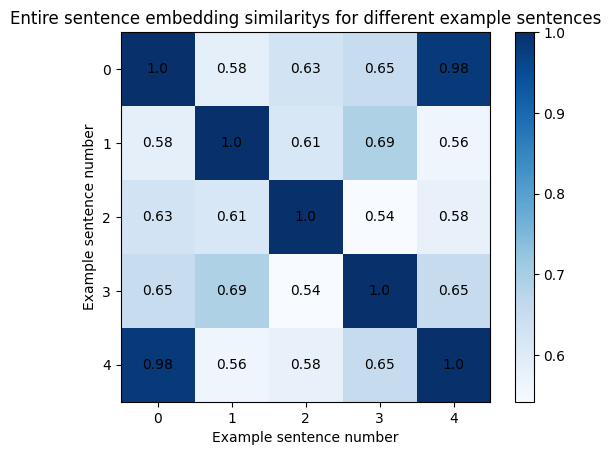

In [44]:
sentence_word_embeddings = []

def get_sentence_embedding(sentence):
    sentence_word_embedding = model_outputs['last_hidden_state'][sentence]

    # a mean is calculated over each word embedding to create an embedding value for the whole sentence
    sentence_embedding = sentence_word_embedding.mean(dim=0)
    
    sentence_embedding = sentence_embedding.detach().numpy()
    return sentence_embedding

for i in range(len(sentences)):
    sentence_word_embeddings.append(get_sentence_embedding(i))


# computing the pairwise distance matrix
sentence_similarities = cdist(sentence_word_embeddings, sentence_word_embeddings, metric='cosine')
# for the scipy.spatial.distance calculation a smaller values indicates greater similarity, this is reversed by subtracting the similarities from 1. 
sentence_similarities = 1 - sentence_similarities

plot_similarity(sentence_similarities, "Entire sentence embedding similaritys for different example sentences")

# 5. Question Answering with Pretrained Transformers

The previous section showed us how to obtain a sequence of contextualised word embeddings using a pretrained transformer. How are these embeddings used to extract answers from documents to a given question?

First, let's load up the [Tweet QA](https://huggingface.co/datasets/tweet_qa) dataset, which we will use to test a pretrained question answering (QA) model. This dataset contains tweets along with questions about the information in the tweets, and a list of correct answers. As we are not going to train our own QA model (it requires a lot of compute time), we will only need the validation set:

In [45]:
from sklearn.metrics import f1_score

val_dataset = load_dataset(
    "squad",
    split="validation",
    cache_dir=cache_dir
)
print(f"Validation dataset with {len(val_dataset)} instances loaded")

Validation dataset with 10570 instances loaded


Now we are working with complete dataset using the HuggingFace datasets library. In the next cell, we create a tokenizer to tokenize the examples in the dataset. We need to choose the right tokenizer for the QA model we want to use, so let's decide to use `"distilbert-base-cased-distilled-squad"` as our pretrained model. This is based on a smaller version of BERT, called Distilbert, which was fine-tuned on the SQUAD question answering dataset.

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad") 

def tokenize_function(dataset):
    # Pass two strings to the tokenizer -- it will concatenate them with a [SEP] special token between them. 
    model_inputs = tokenizer(dataset['question'], dataset['context'], padding="max_length", max_length=200, truncation='only_second')
    return model_inputs

Again, we can use the `map()` method to apply the tokenizer to each example in the dataset. 

In [47]:
val_dataset = val_dataset.map(tokenize_function, batched=True) 

The type of QA model we are going to work with is _extractive_, meaning that the model will extract the answer from the 'context' (also known as the 'passage' or 'source document'). It does this by identifying the index of the start and end tokens of the answer span within the context, or returning `(0, 0)` (the index 0 for both the start and end token) if the context does not contain an answer to the given question. 

As explained in the lectures, BERT forms the basis of the QA model, and maps each token to a contextualised embedding. The QA model then maps each token's contextualised embedding to the probability that the token is the start of the answer span, and to the probability that the token is the end of the answer span. The layers that map the embeddings to the start and end probabilities are known as the 'head' of the model. [The original BERT paper](https://arxiv.org/pdf/1810.04805.pdf) depicts the QA model like this (Devlin et al., 2018):

<img src="bert_qa.png" alt="BERT QA diagram from the slides in week 10 showing the embedding of each token connected to the start and end output layers" width="400px"/>

We can see a similar structure in most neural network models. Our original text classifier from the first notebook used a fully-connected layer to produce a hidden representation of the whole sentence (rather than using BERT to produce a sequence of embeddings). This hidden representation was then fed to an output layer to produce a probability distribution over class labels (rather than the start and end probabilities):

<img src="neural_text_classifier_smaller.png" alt="Neural text classifier diagram from the slides in lecture 8.1" width="400px"/>


<!--With transformers, 
we can do something very similar, by connecting the transfomer's output to a fully-connected layer. However, with BERT, we do not need to pass the embedding of each individual word to the fully-connected layer because there is a special [CLS] token that represents the whole sentence:

The code below shows how to access a tensor containing the [CLS] embeddings:-->

Now, we have the dataset in the right format, let's see how to load a pretrained QA model based on a pretrained transformer. The QA model was trained by taking a pretrained BERT model (pretrained on masked language modelling with unlabelled text), adding the QA head, then further training the complete model on a QA dataset. 

The transformers library provides some useful wrapper classes for loading pretrained models for various NLP tasks, such as QA or text classification. These 'auto' classes are documented here: https://huggingface.co/docs/transformers/model_doc/auto . Let's use an auto class to load the `"distilbert-base-cased-distilled-squad"` pretrained QA model (this code will try to reload the model from a cache or download the model from HuggingFace):

In [48]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

As our model was pretrained, we can use it directly on our Tweet_QA dataset (you may see a message to this effect when you run the cell above the first time). 

So, how do we get a prediction from the model? Let's take a single example from Tweet_QA and obtain the start and end probabilities for all tokens in the 'context':

In [49]:
def predict_nn(qa_model, dataset):
    
    # Switch off dropout
    qa_model.eval()

    # Pass the required inputs from the dataset to the model    
    output = qa_model(attention_mask=torch.tensor(dataset["attention_mask"]), input_ids=torch.tensor(dataset["input_ids"]))
        
    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    probs_start = torch.nn.Softmax(dim=1)(output["start_logits"]).detach().numpy()
    probs_end = torch.nn.Softmax(dim=1)(output["end_logits"]).detach().numpy()
        
    return probs_start, probs_end

# Run the prediction function to get the results for the first 20 examples:
probs_start, probs_end = predict_nn(model, val_dataset[0:20])

Now that we have the probabilities that each token is a start or end token, we combine these probabilities to estimate the probability of each possible answer span. This will allow us to choose the answer span with highest probability. 

In the next cell is our first attempt, which we will need to improve to get valid answers. This code loops through each possible combination of start and end tokens, obtains the start and end probabilities, and extracts the answer text for the corresponding span.

Here we use the start and end probabilities to compute the answer span probability at the place marked inside the predict_answer() function below.

In [50]:
# our example:
example_index = 3

example = val_dataset[example_index]
print(f'CONTEXT = {example["context"]}')
print(f'QUESTION = {example["question"]}')
print(f'LIST OF POSSIBLE ANSWERS = {example["answers"]}')

CONTEXT = Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
QUESTION = Which NFL team won Super Bowl 50?
LIST OF POSSIBLE ANSWERS = {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}


In [51]:
def predict_answer(probs_start, probs_end, input_ids, tokenizer):
    
    input_length = len(input_ids)  # length of the input sequence, in the form "[CLS] question [SEP] context"

    SEP_SPECIAL_TOKEN = 102  # the input id for the sep special token the separates the question from the context. The context starts after this token. 
    PAD_SPECIAL_TOKEN = 0  # the input id for padding tokens added to the end of the context
    
    span_probabilities = []  # save the probabilities here
    spans = []  # save the possible answer spans here
    
    for start_idx in range(0, input_length):
        for end_idx in range(0, input_length):
            
            start_prob = probs_start[start_idx]
            end_prob = probs_end[end_idx]
            
            ### WRITE YOUR ANSWER HERE

            # the probability of the span is the start probabilities times the end probabilities, this esitmates the joint probability ig starting at i and ending at j
            span_prob = start_prob * end_prob
            span_probabilities.append(span_prob)


            ###
            
            span = tokenizer.decode(input_ids[start_idx:end_idx+1])
            spans.append(span)

    # sort the spans according to probability:
    sorted_span_index = np.argsort(span_probabilities)
    
    # print the top 20 answers:
    for i in range(20):
        print(f'Span prob = {span_probabilities[sorted_span_index[-i-1]]}, answer = {spans[sorted_span_index[-i-1]]}')
            
predict_answer(probs_start[example_index], probs_end[example_index], example['input_ids'], tokenizer)

Span prob = 0.3756330609321594, answer = Carolina Panthers
Span prob = 0.286510169506073, answer = 
Span prob = 0.18759368360042572, answer = Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.14308509230613708, answer = Denver Broncos
Span prob = 0.0011476663639768958, answer = Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.0010500344214960933, answer = Panthers
Span prob = 0.0008753704023547471, answer = Broncos
Span prob = 0.0008009026641957462, answer = 
Span prob = 0.00038522674003615975, answer = The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.00029382764478214085, answer = The American Football Conference ( AFC ) champion Denver Broncos
Span prob = 0.0002778444322757423, answer = 
Span prob = 0.00018871514475904405, answer = American Football Conference ( AFC ) champi

To improve the predict_answer() function, the range that is iterated over can be modified. Currently this approach checks over the entire input length range for both start and end idx. Due to the format of a SQuAD dataset interating over the entire range means that parts of the question can be given in the answer which would be invalid. As well as this because the end_idx can be less than the start_idx some invalid spans presenting as blank answers can be returned. By making sure we start only after the [SEP] token in the start_idx range means we only consider the context (not the question). Modifying the end_idx iteration range by only starting at the start_idx ensures the end_idx cannot be less than the start_idx.



In [52]:
def predict_answer(probs_start, probs_end, input_ids, tokenizer):
    
    input_length = len(input_ids)  # length of the input sequence, in the form "[CLS] question [SEP] context"

    SEP_SPECIAL_TOKEN = 102  # the input id for the sep special token the separates the question from the context. The context starts after this token. 
    PAD_SPECIAL_TOKEN = 0  # the input id for padding tokens added to the end of the context
    
    span_probabilities = []  # save the probabilities here
    spans = []  # save the possible answer spans here
    ###
    context_start_index = input_ids.index(SEP_SPECIAL_TOKEN) + 1  # ensure that we start only after the [SEP] token

    for start_idx in range(context_start_index, input_length):
        for end_idx in range(start_idx, input_length):
    ###            
            start_prob = probs_start[start_idx]
            end_prob = probs_end[end_idx]

            # the probability of the span is the start probabilities times the end probabilities, this esitmates the joint probability ig starting at i and ending at j
            span_prob = start_prob * end_prob
            span_probabilities.append(span_prob)
            
            span = tokenizer.decode(input_ids[start_idx:end_idx+1])
            spans.append(span)

    # sort the spans according to probability:
    sorted_span_index = np.argsort(span_probabilities)
    
    # print the top 20 answers:
    for i in range(20):
        print(f'Span prob = {span_probabilities[sorted_span_index[-i-1]]}, answer = {spans[sorted_span_index[-i-1]]}')
            
predict_answer(probs_start[example_index], probs_end[example_index], example['input_ids'], tokenizer)

Span prob = 0.3756330609321594, answer = Carolina Panthers
Span prob = 0.18759368360042572, answer = Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.14308509230613708, answer = Denver Broncos
Span prob = 0.0011476663639768958, answer = Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.0010500344214960933, answer = Panthers
Span prob = 0.0008753704023547471, answer = Broncos
Span prob = 0.00038522674003615975, answer = The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.00029382764478214085, answer = The American Football Conference ( AFC ) champion Denver Broncos
Span prob = 0.00018871514475904405, answer = American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers
Span prob = 0.0001818591117626056, a

As we are using a pretrained model (BERT, specifically distilbert-base-cased-distilled-squad which has been fine-tuned for SQuAD datasets) the performace will depend on corpus that this model was trained on. BERT is primarily trained on Wikipedia and BookCorpus, we would expect the language from the Tweet QA dataset to differ significantly from this. Fine-tuning the model on this new dataset would be a good way to improve performance. When fine-tuning a pretrained model the gradients are back-propogated through the existing model and wights are updated, as would have happend in the intial training phase of the model. As the Tweet QA dataset is fairly large, fine-tuning the model without freezing any of the layers would likely be a good approach as it can better adapt to the context of tweets however the risk of overfitting is higher so this would need to be monitored. Fine-tuning is often most effective when downstream tasks are simillar which in the case here is true as we are using a BERT model that has been fine-tuned for SQuAD datasets. The only difference is that the context is tweets rather than paragraphs of text.

As well as answering ad-hoc queries, question answering models can help us to extract structured information about entities of interest from a large set of documents. Suppose that we want to automatically collect information on tech companies, such as Apple and Open AI. We want to extract information about each company's activities from social media, including the names and release dates of new products and services, the company's earnings in a specific year, and who its CEO is.  

With a list of tech company names, named entity recognition can be used as a preprocessing step to identify comapny names in the dataset. Given we have a list of tech company names this should be used to enchance the NER approach by using this list to validate results. NER is better than just searching for the companies in text because there will be variation in the use of company names which NER can account for. For example 'Apple' could be refering to the fruit or the company. Once we have tagged entities we need to formulate a list of questions for each company that we want to answer. This would involve creating a list of the questions we want to answer for each company. Once we have this we can then for each company and for each required question use the predict feature of our QA model to get answers. These answers can be further refined using the company name list to validate the results and remove invalid answers. The top remaining answers can then be stored for each question for each company.

# 6. Transformer-based Text Classifiers

The previous section showed us how to use a pretrained QA model based on a pretrained transformer. In this section, you will learn how to construct and train a text classifier on top of a pretrained transformer. 

We will use the [TweetEval emotion](https://huggingface.co/datasets/tweet_eval) dataset to train and test a classifier. The task is to classify tweets into one of  0: anger, 1: joy, 2: optimism, or 3: sadness.

To begin you will need to instantiate a suitable model.

Here we find an AutoModel class that constructs a text classifier from the pretrained TinyBERT model, "huawei-noah/TinyBERT_General_4L_312D". Create the `model` object in the cell below using this class.

In [53]:
from transformers import AutoModelForSequenceClassification
num_labels = 4 
model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



(https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)
The most notible difference between the QA model and the text classifier model is in the inputs and outputs. While both approaches used split the input document into tokens for classification there is no split between question and context, there is just a single sentence. Classification is a sequence-level task whereas QA is a token-level task. Models fine-tuned to complete specific tasks have an additional output layer, the output, instead of a start and end position in the text, indicating the most likely span of text that answers a given question will now be just a class label. The model itself will also have different weights in the network, these weights are learned in the fine-tuning process. For QA the model must understand the context of input question and find the context in the input context. For classification the model must associate the input text with a possible output label. 

For the QA task, the complete model was pretrained and we could apply it to a dataset without further training. However, for our poem sentiment classification task,
we will need to train our model before we can use it (you may see a message in the output of the last cell telling you this). 

Next, let's learn how to train our model. For some tasks it is not necessary to update the weights in the BERT model itself, so we can freeze them to save a lot of computation time. We can do this as follows. Since our pretrained model is based on BERT, we can access the weights inside BERT through the variable `model.bert`.

In [54]:
for param in model.bert.parameters():
    param.requires_grad = False

To train our model, we can make use of the Trainer class, which encapsulates a lot of the complex training steps and avoids the need to define our own training function, as we did in the previous notebook (we don't need to write our own `train_nn`).

First, define some settings for the training process. This is where we can set training hyperparameters:

In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=10, # A sensible and sufficient number to use for the to-dos below
    per_device_train_batch_size=8,  # you can decrease this if memory usage is too high while training
    logging_steps=50,  # how often to print progress during training
)

Next, create a trainer object. Note that the next cell will currently fail with an error, because the variables `em_train_dataset` and `em_val_dataset` do not exist yet! Don't worry, we'll fix this later. 

In [56]:
from transformers import Trainer
from torch import nn

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=em_train_dataset,
#     eval_dataset=em_val_dataset,
# )

To train the model, you will need to call `trainer.train()`.

Once the model is trained, we can obtain predictions using the function below. Notice that it is simpler than obtaining the spans for QA -- we simply get the logits for each tweet in the test set, then apply argmax over the classes to find the most probable class for each tweet:

In [57]:
def predict_nn(trained_model, test_dataset):

    # Switch off dropout
    trained_model.eval()
    
    # Pass the required items from the dataset to the model    
    output = trained_model(attention_mask=torch.tensor(test_dataset["attention_mask"]), input_ids=torch.tensor(test_dataset["input_ids"]))
                        
    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    pred_labs = np.argmax(output["logits"].detach().numpy(), axis=1)

    return pred_labs

You should now have all the bits and pieces needed to build and train a text classifier. Let's put them all together...

Here we implement and test a classifier for the [Emotion](https://huggingface.co/datasets/tweet_eval) dataset using a pretrained transformer. Evaluate the classifier with both frozen and unfrozen (i.e., fine-tuned) parameters in the pretrained transformer. Choose a suitable evaluation metric and provide a comparison of the results below, including a brief explanation  (1-2 sentences) for any differences you observe between the frozen and unfrozen variants. Make sure to comment your code.

Notes: 
 * Strong classifier performance is not required to achive good marks -- rather, we award marks for implementing and testing a transformer-based classifier correctly.
 * You may implement any suitable kind of classifier you like, as long as you are using a pretrained transformer model.
 * 'tiny' BERT variants such as TinyBERT and roberta-tiny are recommended because they are small enough to fine-tune with a typical laptop CPU. We recommend sticking with these smaller pretrained models unless you have access to a GPU, e.g., via Google Colab. 

**Results:**

Frozen: Micro F1 Score = 0.7967914438502673 Frozen: Macro F1 Score = 0.7263282143015635 Accuracy = 0.7967914438502673

Unfrozen: Micro F1 Score = 0.7887700534759359 Frozen: Macro F1 Score = 0.7292671991032647 Accuracy = 0.7887700534759359

This model shows good performance for both frozen and unfrozen approaches with slightly better performance for the frozen model. Both models showed very good performance in predicting classes 0,1 and 3 and poor performace for class 2, this is likely becuase of class imbalance in the training data. 



tensor([1.], device='mps:0')
Train dataset with 3257 instances loaded
Validation dataset with 374 instances loaded


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/C289216/miniconda3/envs/datasci/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfig

  0%|          | 0/4080 [00:00<?, ?it/s]

{'loss': 1.2339, 'grad_norm': 16.009841918945312, 'learning_rate': 4.9387254901960786e-05, 'epoch': 0.12}
{'loss': 0.9862, 'grad_norm': 10.616930961608887, 'learning_rate': 4.877450980392157e-05, 'epoch': 0.25}
{'loss': 0.8014, 'grad_norm': 35.767921447753906, 'learning_rate': 4.816176470588236e-05, 'epoch': 0.37}
{'loss': 0.7131, 'grad_norm': 6.483719825744629, 'learning_rate': 4.7549019607843135e-05, 'epoch': 0.49}
{'loss': 0.7026, 'grad_norm': 10.569408416748047, 'learning_rate': 4.6936274509803925e-05, 'epoch': 0.61}
{'loss': 0.6741, 'grad_norm': 26.182552337646484, 'learning_rate': 4.632352941176471e-05, 'epoch': 0.74}
{'loss': 0.7002, 'grad_norm': 14.549432754516602, 'learning_rate': 4.571078431372549e-05, 'epoch': 0.86}
{'loss': 0.6863, 'grad_norm': 11.209315299987793, 'learning_rate': 4.5098039215686275e-05, 'epoch': 0.98}
{'loss': 0.3808, 'grad_norm': 2.4471166133880615, 'learning_rate': 4.448529411764706e-05, 'epoch': 1.1}
{'loss': 0.3447, 'grad_norm': 2.2871310710906982, 'le

  0%|          | 0/47 [00:00<?, ?it/s]

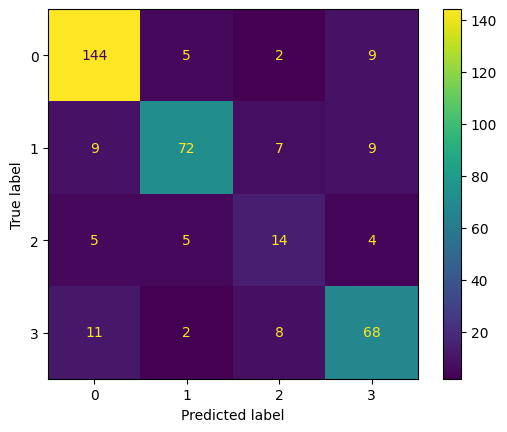

Frozen: Micro F1 Score = 0.7967914438502673 Frozen: Macro F1 Score = 0.7263282143015635 Accuracy = 0.7967914438502673


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/C289216/miniconda3/envs/datasci/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/4080 [00:00<?, ?it/s]

{'loss': 1.1686, 'grad_norm': 18.704633712768555, 'learning_rate': 4.9387254901960786e-05, 'epoch': 0.12}
{'loss': 0.8461, 'grad_norm': 25.330907821655273, 'learning_rate': 4.877450980392157e-05, 'epoch': 0.25}
{'loss': 0.7771, 'grad_norm': 16.333826065063477, 'learning_rate': 4.816176470588236e-05, 'epoch': 0.37}
{'loss': 0.6951, 'grad_norm': 4.725244045257568, 'learning_rate': 4.7549019607843135e-05, 'epoch': 0.49}
{'loss': 0.702, 'grad_norm': 11.99639892578125, 'learning_rate': 4.6936274509803925e-05, 'epoch': 0.61}
{'loss': 0.7049, 'grad_norm': 25.550018310546875, 'learning_rate': 4.632352941176471e-05, 'epoch': 0.74}
{'loss': 0.6872, 'grad_norm': 16.527263641357422, 'learning_rate': 4.571078431372549e-05, 'epoch': 0.86}
{'loss': 0.7217, 'grad_norm': 11.38627815246582, 'learning_rate': 4.5098039215686275e-05, 'epoch': 0.98}
{'loss': 0.3985, 'grad_norm': 9.141362190246582, 'learning_rate': 4.448529411764706e-05, 'epoch': 1.1}
{'loss': 0.3851, 'grad_norm': 13.269014358520508, 'learni

  0%|          | 0/47 [00:00<?, ?it/s]

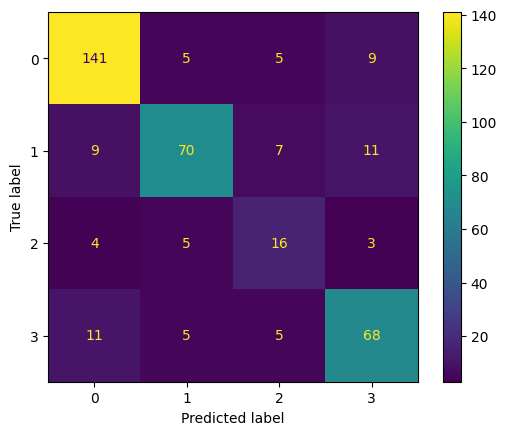

Unfrozen: Micro F1 Score = 0.7887700534759359 Frozen: Macro F1 Score = 0.7292671991032647 Accuracy = 0.7887700534759359


In [58]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# load dataset
em_train_dataset = load_dataset(
    "tweet_eval", "emotion",
    split="train",
    cache_dir=cache_dir
)

em_val_dataset = load_dataset(
    "tweet_eval", "emotion",
    split="validation",
    cache_dir=cache_dir
)
print(f"Train dataset with {len(em_train_dataset)} instances loaded")
print(f"Validation dataset with {len(em_val_dataset)} instances loaded")

num_labels = 4 
# bert_model = "huawei-noah/TinyBERT_General_4L_312D"
bert_model = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=num_labels)


# tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained(bert_model) 

def tokenize_function(dataset):
    return tokenizer(dataset['text'], padding='max_length', truncation=True, max_length=512)

em_train_dataset = em_train_dataset.map(tokenize_function, batched=True)
em_val_dataset = em_val_dataset.map(tokenize_function, batched=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_micro= f1_score(labels, preds, average='micro')
    f1_macro= f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    conf_mat = confusion_matrix(labels, preds)
    # Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(conf_mat).plot(include_values=True)
    plt.show()
    return {
        'accuracy': acc,
        # 'precision': precision,
        # 'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

# frozen parameters
model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=4).eval()
fine_tune_fr = Trainer(
    model=model,
    args=training_args,
    train_dataset=em_train_dataset,
    eval_dataset=em_val_dataset,
    compute_metrics=compute_metrics,
)
fine_tune_fr.train()

eval_results_frozen = fine_tune_fr.evaluate()
print(f"Frozen: Micro F1 Score = {eval_results_frozen['eval_f1_micro']} Frozen: Macro F1 Score = {eval_results_frozen['eval_f1_macro']} Accuracy = {eval_results_frozen['eval_accuracy']}")

# Train the model with unfrozen parameters
model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=4)
fine_tune_unfr = Trainer(
    model=model,
    args=training_args,
    train_dataset=em_train_dataset,
    eval_dataset=em_val_dataset,
    compute_metrics=compute_metrics,
)
fine_tune_unfr.train()

eval_results_unfrozen = fine_tune_unfr.evaluate()
print(f"Unfrozen: Micro F1 Score = {eval_results_unfrozen['eval_f1_micro']} Frozen: Macro F1 Score = {eval_results_unfrozen['eval_f1_macro']} Accuracy = {eval_results_unfrozen['eval_accuracy']}")

There are two type of transfer used here. Frozen parameter fine-tuning measns that it is just the final layer that is trained which if beneficial for training to small datasets that are not significantly different from the original dataset.

Unfrozen parameter fine-tuning allows all parameters to be updating with training of the new dataset. This is good for large datasets or if the dataset used for fine-tuning is significantly different from the one used to orignially train the model. 

In [59]:
from torch.nn.functional import softmax

# sentence = "Finally nailed that tricky piece of code after hours of head-scratching, and the feeling of triumph is absolutely electric! 🥳 There's nothing quite like the rush of solving a puzzle and watching your creation come to life. Pure joy!"
sentence = "A torch lights up the night A torch shows the way A torch can be put out And never shine again A torch can be passed From one to another A torch can light the way To a new tomorrow"

inputs = tokenizer(sentence, return_tensors="pt", padding='max_length', truncation=True, max_length=512)

inputs = {k: v.to(model.device) for k, v in inputs.items()}

def predict_nn(trained_model, test_dataset):
    # Switch off dropout
    trained_model.eval()
    
    # Pass the required items from the dataset to the model    
    output = trained_model(attention_mask=torch.tensor(test_dataset["attention_mask"]), input_ids=torch.tensor(test_dataset["input_ids"]))
                        
    # Apply softmax to the logits to get probabilities
    probs = softmax(output.logits, dim=-1)
    
    # Convert the probabilities to a Python list
    probs = probs.tolist()

    return probs

probabilities = predict_nn(model, inputs)

labels = ['anger', 'joy', 'optimism', 'sadness']

probabilities

for label, prob in zip(labels, probabilities[0]):
    print(f"{label}: {prob}")


anger: 8.767021063249558e-05
joy: 0.001831050612963736
optimism: 0.9980108141899109
sadness: 7.044721860438585e-05


/var/folders/8b/nnqddvld60bdl36420tfgj5m0000gn/T/ipykernel_81222/225683249.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = trained_model(attention_mask=torch.tensor(test_dataset["attention_mask"]), input_ids=torch.tensor(test_dataset["input_ids"]))
